# Spam Classification

In [1]:
# importing necessary libraries
import re
from pathlib import Path
from collections import Counter

import joblib
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from lime.lime_text import LimeTextExplainer

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## 1. Initial Setup

In [2]:
seed = 42

label_encoder = LabelEncoder()
lemmatizer = WordNetLemmatizer()
nltk.download("wordnet", quiet=True)
stop_words = stopwords.words("english")

pd.set_option("display.max_colwidth", None)

tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

# https://stackoverflow.com/a/5552623/7097413
df = pd.read_csv("./dataset/spam.csv", encoding="ISO-8859-1")
df.rename(columns = {"v1": "label"}, inplace=True)

df.head()

,label,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


## 2. Data Cleaning & Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
print(f"Duplicates before: {df.duplicated().sum()}")

df = df.drop_duplicates()

print(f"Duplicates after: {df.duplicated().sum()}")

Duplicates before: 403
Duplicates after: 0


In [5]:
df[df["Unnamed: 2"].notna()].head(10)

,label,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML",PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... But if the person is so special,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAROUND! HOWDY GORGEOUS,"HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\""""",NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to 62468""",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics professors wer calld &amp; they wer askd 2 sit in an aeroplane. Aftr they sat they wer told dat the plane ws made by their students. Dey all hurried out of d plane.. Bt only 1 didnt move... He said:\if it is made by my students,"this wont even start........ Datz confidence..""",NaN,NaN
1038,ham,"Edison has rightly said, \A fool can ask more questions than a wise man can answer\"" Now you know why all of us are speechless during ViVa.. GM",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy throws a luv letter on a gal but falls on her brothers head whos a gay",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,"just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\""""",NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? \""Margaret Hello\"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN
1428,ham,"Tell you what, if you make a little spreadsheet and track whose idea it was to smoke to determine who \smokes too much\"" for the entire month of february","I'll come up""",NaN,NaN


In [6]:
# combining text columns into a single feature for modeling
columns_to_drop = df.columns.to_list()[2:]
columns_to_merge = df.columns.to_list()[1:]

df["text_combined"] = df[columns_to_merge].fillna("").agg(" ".join, axis=1)

df[df["Unnamed: 2"].notna()][["v2", "text_combined"]].head(10)

,v2,text_combined
95,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML","Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML PO Box 5249 MK17 92H. 450Ppw 16"""
281,\Wen u miss someone,"\Wen u miss someone the person is definitely special for u..... But if the person is so special why to miss them just Keep-in-touch\"" gdeve.."""
444,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAROUND! HOWDY GORGEOUS,"\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAROUND! HOWDY GORGEOUS HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\"""""
671,SMS. ac sun0819 posts HELLO:\You seem cool,"SMS. ac sun0819 posts HELLO:\You seem cool wanted to say hi. HI!!!\"" Stop? Send STOP to 62468"""
710,Height of Confidence: All the Aeronautics professors wer calld &amp; they wer askd 2 sit in an aeroplane. Aftr they sat they wer told dat the plane ws made by their students. Dey all hurried out of d plane.. Bt only 1 didnt move... He said:\if it is made by my students,"Height of Confidence: All the Aeronautics professors wer calld &amp; they wer askd 2 sit in an aeroplane. Aftr they sat they wer told dat the plane ws made by their students. Dey all hurried out of d plane.. Bt only 1 didnt move... He said:\if it is made by my students this wont even start........ Datz confidence.."""
1038,"Edison has rightly said, \A fool can ask more questions than a wise man can answer\"" Now you know why all of us are speechless during ViVa.. GM","Edison has rightly said, \A fool can ask more questions than a wise man can answer\"" Now you know why all of us are speechless during ViVa.. GM GN GE GNT:-)"""
1127,"Height of \Oh shit....!!\"" situation: A guy throws a luv letter on a gal but falls on her brothers head whos a gay","Height of \Oh shit....!!\"" situation: A guy throws a luv letter on a gal but falls on her brothers head whos a gay .;-):-D"""
1266,\Hey sorry I didntgive ya a a bellearlier hunny,"\Hey sorry I didntgive ya a a bellearlier hunny just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\"""""
1384,"Storming msg: Wen u lift d phne, u say \HELLO\"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? \""Margaret Hello\"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person","Storming msg: Wen u lift d phne, u say \HELLO\"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? \""Margaret Hello\"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person bt not his girlfrnd... G o o d n i g h t . . .@"""
1428,"Tell you what, if you make a little spreadsheet and track whose idea it was to smoke to determine who \smokes too much\"" for the entire month of february","Tell you what, if you make a little spreadsheet and track whose idea it was to smoke to determine who \smokes too much\"" for the entire month of february I'll come up"""


In [7]:
# drop unnecessary columns after merging
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5169 non-null   object
 1   v2             5169 non-null   object
 2   text_combined  5169 non-null   object
dtypes: object(3)
memory usage: 161.5+ KB


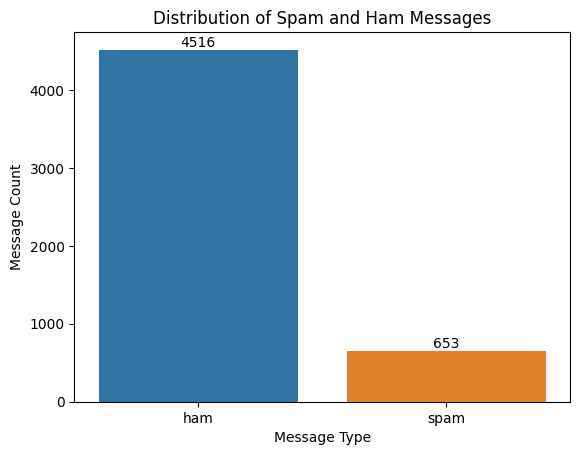

In [8]:
# visualizing the distribution of spam and non-spam messages

ax = sns.countplot(data=df, x="label", hue="label")
ax.set(title="Distribution of Spam and Ham Messages", xlabel="Message Type", ylabel="Message Count")

for bar in ax.patches:
    yval = int(bar.get_height())
    ax.annotate(f'{yval}', (bar.get_x() + bar.get_width()/2, bar.get_height()), ha="center", va="bottom")

plt.show()

In [9]:
# feature engineering
df["char_count"] = df["text_combined"].apply(len)
df["capital_count"] = df["text_combined"].apply(lambda x: sum(1 for c in x if c.isupper()))
df["special_char_count"] = df["text_combined"].apply(lambda x: sum(1 for c in x if not c.isalnum()))

df.describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,5169.0,82.527762,58.467143,5.0,39.0,64.0,122.0,913.0
capital_count,5169.0,5.468563,11.754759,0.0,1.0,2.0,4.0,129.0
special_char_count,5169.0,21.778874,14.370338,3.0,11.0,18.0,30.0,256.0


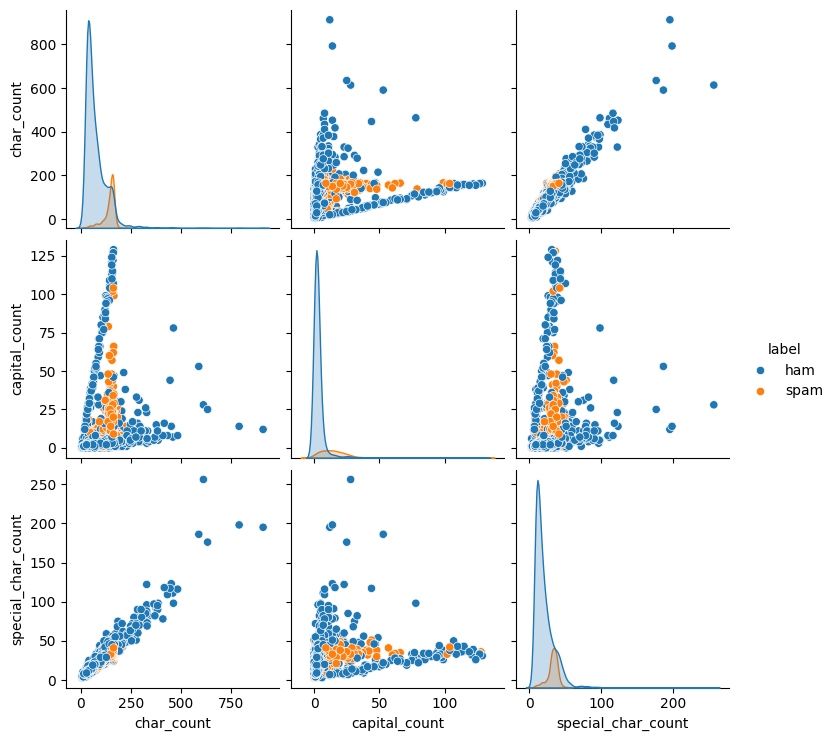

In [10]:
# plotting pairplot for outlier detection
fg = sns.pairplot(df, hue="label")
plt.show(fg)

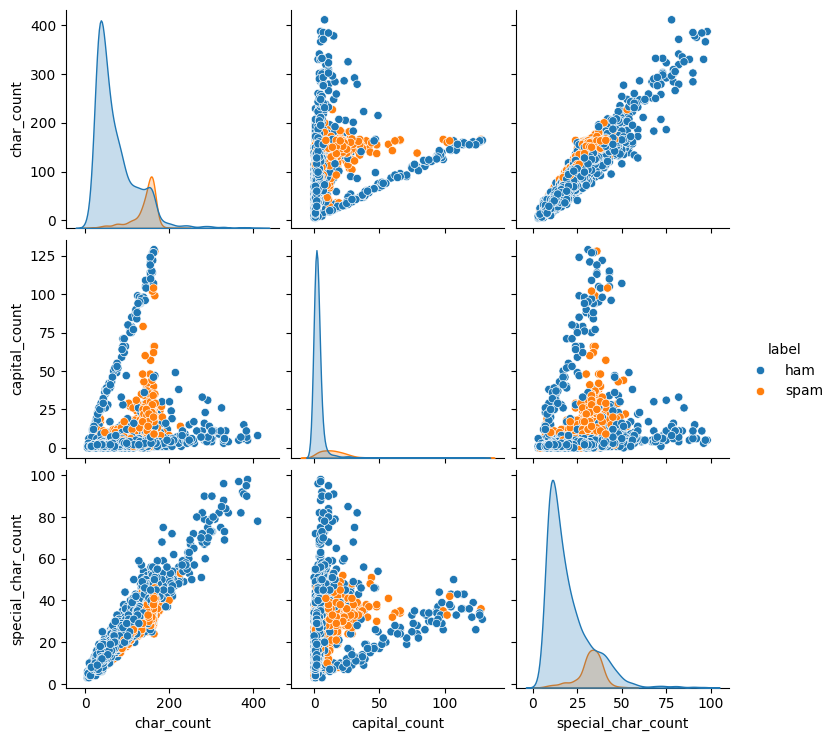

In [11]:
# removing outliers and re-plotting pairplot
df = df[(df["char_count"] < 450) & (df["special_char_count"] <= 100)]
fg = sns.pairplot(df, hue="label")
plt.show(fg)

<Axes: >

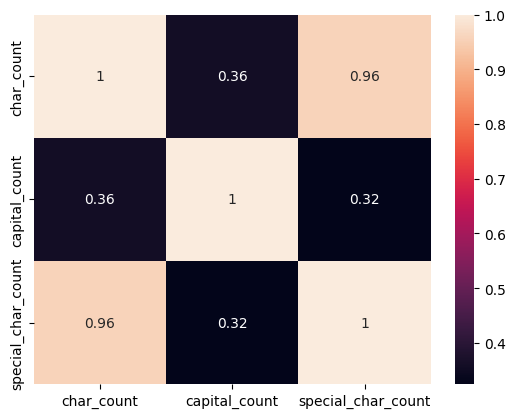

In [12]:
sns.heatmap(df.select_dtypes(exclude="object").corr(), annot=True)

In [13]:
df = df.drop(columns=["special_char_count"])

## 3. Data Preprocessing

In [14]:
def preprocess(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub("\s+", " ", text).strip()
    text = text.lower()

    tokens = wordpunct_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    tokens = " ".join(tokens)
    
    return tokens

# example of preprocessing
preprocess("Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's application churches dogs")

'text fa receive entry question std txt rate c apply application church dog'

In [15]:
# preprocess text and encode labels
df["processed_text"] = df["text_combined"].apply(lambda x: preprocess(x))
df["label"] = label_encoder.fit_transform(df["label"])

df[["label", "processed_text"]].head(10)

,label,processed_text
0,0,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though
5,1,freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv
6,0,even brother like speak treat like aid patent
7,0,per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune
8,1,winner valued network customer selected receivea prize reward claim call claim code kl valid hour
9,1,mobile month u r entitled update latest colour mobile camera free call mobile update co free


In [16]:
# define features and labels
X = df["processed_text"]
y = df["label"]

# train, test and validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, stratify=y_train)

# fit tfidf vectorizer on the training data and transform sets
tfidf.fit(X_train_main)

X_train_tfidf = tfidf.transform(X_train_main)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [17]:
# handling class imbalance
over = SMOTE(random_state=seed, sampling_strategy=0.4)
under = RandomUnderSampler(random_state=seed, sampling_strategy=0.4)

steps = [("oversample", over), ("undersample", under)]
pipeline = Pipeline(steps=steps)

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_tfidf, y_train_main)

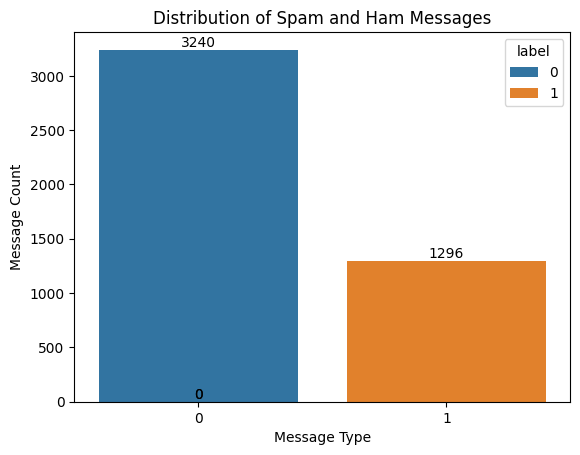

In [18]:
# visualizing the distribution of spam and non-spam messages after addressing class imbalance
smote_counts = pd.DataFrame({"label": y_train_resampled})

ax = sns.countplot(data=smote_counts, x="label", hue="label")
ax.set(title="Distribution of Spam and Ham Messages", xlabel="Message Type", ylabel="Message Count")

for bar in ax.patches:
    yval = int(bar.get_height())
    ax.annotate(f'{yval}', (bar.get_x() + bar.get_width()/2, bar.get_height()), ha="center", va="bottom")

plt.show()

## 4. Model Training and Hyperparameter Tuning

In [19]:
# classifiers and respective parameter grids
classifiers = {
    "SVM": SVC(),
    "XGB": XGBClassifier(),
    "KNN": KNeighborsClassifier(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
}

# calculate scale_pos_weight for XGBoost weight adjustment
counter = Counter(y_train_resampled)
scale_pos_weight = counter[0] / counter[1]

param_grids = {
    "SVM": {
        "degree": [3, 4, 5], # degree of polynomial kernel
        "probability": [True],
        "C": [0.1, 1, 10, 100], # regularization
        "gamma": ["scale", "auto"], # kernel coefficient
        "kernel": ["linear", "rbf", "poly"], # kernel types
        "class_weight": [None, "balanced"]  # class weight adjustment
    },
    "XGB": {
        "max_depth": [3, 5, 7], # maximum depth of trees
        "subsample": [0.6, 0.8, 1.0], # subsample ratio
        "n_estimators": [50, 100, 200], # number of boosting rounds
        "learning_rate": [0.01, 0.1, 0.2], # step size shrinkage
        "colsample_bytree": [0.6, 0.8, 1.0], # feature subsampling
        "scale_pos_weight": [1, scale_pos_weight],  # class balancing
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9], # number of neighbors
        "weights": ["uniform", "distance"], #weight functions
        "metric": ['euclidean', 'manhattan'] # distance metrics
    },
    "MultinomialNB": {
        "fit_prior": [True, False],
        "alpha": [0.1, 0.5, 1.0, 2.0] # smoothing parameter
    },
    "LogisticRegression": {
        "penalty": ["l2"], #regularization
        "solver": ["lbfgs"], # inverse regularization srength
        "C": [0.01, 0.1, 1, 10], # solvers supporting l1/l2 penalties
        "class_weight": [None, "balanced"]  # class weight adjustment
    }
}

best_estimators = {}
grid_search_results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# train and tune models using GridSearchCV
for name, classifier in tqdm(classifiers.items(), desc="Tuning Models"):
    grid = GridSearchCV(classifier, param_grids[name], cv=cv, scoring="f1")
    grid.fit(X_train_resampled, y_train_resampled)

    best_estimators[name] = grid.best_estimator_
    
    grid_search_results.append({
        "Model": name,
        "Best Parameters": grid.best_params_,
        "Best F1 Score": grid.best_score_
    })

grid_search_results_df = pd.DataFrame(grid_search_results)
grid_search_results_df

Tuning Models: 100%|█| 5/5 [26:10<00:00, 31


,Model,Best Parameters,Best F1 Score
0,SVM,"{'C': 1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}",0.986730
1,XGB,"{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 1.0}",0.961067
2,KNN,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}",0.967606
3,MultinomialNB,"{'alpha': 0.5, 'fit_prior': True}",0.964101
4,LogisticRegression,"{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}",0.979528


## 5. Model Evaluation

In [20]:
validation_results = []

for name, best_estimator in best_estimators.items():
    train_f1 = grid_search_results_df.loc[grid_search_results_df["Model"] == name, "Best F1 Score"].values[0]

    # validation set evaluation
    y_val_pred = best_estimator.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, y_val_pred, average="weighted")

    # test set evaluation
    y_test_pred = best_estimator.predict(X_test_tfidf)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    validation_results.append({
        "Model": name,
        "Training F1 Score": train_f1,
        "Validation F1 Score": val_f1,
        "Test F1 Score": test_f1
    })
    
    print(f"\n------------------ Evaluating {name} ------------------")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    # check for overfitting by comparing train, validation, and test scores
    if train_f1 > val_f1 + 0.05 or train_f1 > test_f1 + 0.05:
        print(f"\nPotential Overfitting Detected in {name}!")
    else:
        print(f"\nNo significant overfitting detected in {name}.")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=["Ham", "Spam"]))

    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=["Ham", "Spam"]))


------------------ Evaluating SVM ------------------
Training F1 Score: 0.9867
Validation F1 Score: 0.9803
Test F1 Score: 0.9821

No significant overfitting detected in SVM.

Validation Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       361
        Spam       0.96      0.88      0.92        52

    accuracy                           0.98       413
   macro avg       0.97      0.94      0.95       413
weighted avg       0.98      0.98      0.98       413

Test Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       901
        Spam       0.99      0.87      0.93       131

    accuracy                           0.98      1032
   macro avg       0.99      0.93      0.96      1032
weighted avg       0.98      0.98      0.98      1032


------------------ Evaluating XGB ------------------
Training F1 Score: 0.9611
Validation F1 Score: 0.9649


In [21]:
validation_results_df = pd.DataFrame(validation_results)
validation_results_df

,Model,Training F1 Score,Validation F1 Score,Test F1 Score
0,SVM,0.986730,0.980295,0.982068
1,XGB,0.961067,0.964875,0.977372
2,KNN,0.967606,0.961407,0.956271
3,MultinomialNB,0.964101,0.964387,0.986521
4,LogisticRegression,0.979528,0.978118,0.989358


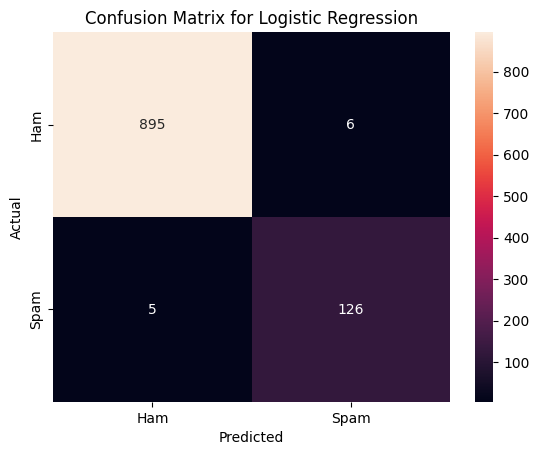

In [22]:
# generate confusion matrix for the best model
best_model = best_estimators["LogisticRegression"]

y_test_pred = best_model.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for Logistic Regression")

plt.show()

## 6. Inference on New Data

In [23]:
label_map = {0: "ham", 1: "spam"}

inference_data = [
    "Congratulations! You’ve been selected to receive a FREE iPhone! Click here to claim your prize here. Hurry, this offer won’t last long!",
    "Tired of bad credit? We can help! Improve your credit score by 100 points or more within 7 days. No credit checks, no hassle! Visit this link to learn more.",
    "Claim your $1,000 cash prize NOW! Hurry, this offer ends soon. Click here and start earning now!",
    "Are you still up for dinner tomorrow night at 7 PM? Let me know if you want to change the time or location. Cheers, Sarah",
    "Attached is your flight itinerary for the upcoming trip to Chicago. Please review the details and contact us if you have any questions.",
    "Hey, want to grab lunch today at noon? Let’s catch up over coffee tomorrow at 10 AM."
]

# preprocess and transform new data using the same vectorizer
inference_data = [preprocess(data) for data in inference_data]
inference_data_transformed = tfidf.transform(inference_data)

predictions = best_model.predict(inference_data_transformed)

predicted_labels = [label_map[pred] for pred in predictions]

# Output the results
for i, message in enumerate(inference_data):
    print(f"\nMessage: {message}")
    print(f"Predicted as: {predicted_labels[i]}")


Message: congratulation selected receive free iphone click claim prize hurry offer last long
Predicted as: spam

Message: tired bad credit help improve credit score point within day credit check hassle visit link learn
Predicted as: spam

Message: claim cash prize hurry offer end soon click start earning
Predicted as: spam

Message: still dinner tomorrow night pm let know want change time location cheer sarah
Predicted as: ham

Message: attached flight itinerary upcoming trip chicago please review detail contact u question
Predicted as: ham

Message: hey want grab lunch today noon let catch coffee tomorrow
Predicted as: ham


## 7. Model Saving and Reloading

In [24]:
folder_path = Path("./artefacts")
folder_path.mkdir(parents=True, exist_ok=True)

# save model and vectorizer
joblib.dump(tfidf, "artefacts/tfidf_vectorizer.pkl", compress=3)
joblib.dump(best_estimators["LogisticRegression"], "artefacts/logistic_regression_model.pkl", compress=3)

# load saved model and vectorizer
tfidf_loaded = joblib.load("artefacts/tfidf_vectorizer.pkl")
model_loaded = joblib.load("artefacts/logistic_regression_model.pkl")

inference_data_transformed = tfidf.transform(inference_data)
predictions = model_loaded.predict(inference_data_transformed)

predicted_labels = [label_map[pred] for pred in predictions]

for i, message in enumerate(inference_data):
    print(f"\nMessage: {message}")
    print(f"Predicted as: {predicted_labels[i]}")


Message: congratulation selected receive free iphone click claim prize hurry offer last long
Predicted as: spam

Message: tired bad credit help improve credit score point within day credit check hassle visit link learn
Predicted as: spam

Message: claim cash prize hurry offer end soon click start earning
Predicted as: spam

Message: still dinner tomorrow night pm let know want change time location cheer sarah
Predicted as: ham

Message: attached flight itinerary upcoming trip chicago please review detail contact u question
Predicted as: ham

Message: hey want grab lunch today noon let catch coffee tomorrow
Predicted as: ham


## 8. Interpreting Model Results

In [38]:
tfidf_loaded = joblib.load("artefacts/tfidf_vectorizer.pkl")
model_loaded = joblib.load("artefacts/logistic_regression_model.pkl")

pipeline = make_pipeline(tfidf_loaded, model_loaded)
explainer = LimeTextExplainer(class_names=["ham", "spam"])
sentence = "Hey you won 10000000. Click the link below to access it."

exp = explainer.explain_instance(sentence, pipeline.predict_proba)

exp.show_in_notebook()
exp.as_list()

[('Hey', -0.1839604890338234),
 ('link', 0.1182444428899399),
 ('access', 0.11053167690939399),
 ('Click', 0.0747603361448301),
 ('you', 0.0019361271269765312),
 ('won', 0.0014577882291112855),
 ('10000000', 0.0009371628595501216),
 ('the', 0.000629927523802427),
 ('it', -0.00060743830590581),
 ('to', -0.00031071780493109645)]